In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition.zip -d ./data/
!rm -rf data/flowers/flowers

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 99% 223M/225M [00:09<00:00, 28.4MB/s]
100% 225M/225M [00:09<00:00, 24.9MB/s]
Archive:  flowers-recognition.zip
  inflating: ./data/flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: ./data/flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: ./data/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: ./data/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: ./data/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: ./data/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: ./data/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: ./data/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: ./data/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: ./data/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: ./data/flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: ./data/flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: ./data/flowers/

In [ ]:
import torch
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import numpy as np
from torch.utils.data import DataLoader

A continuación cargamos las imágenes para poder analizarlas.

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])
dataset = ImageFolder('data/flowers', transform=transform)
classes = dataset.classes
data_loader = DataLoader(dataset, batch_size=20, shuffle=True)

Creamos una función auxiliar para mostrar las imágenes y mostramos las 20 primeras.

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
dataiter = iter(data_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

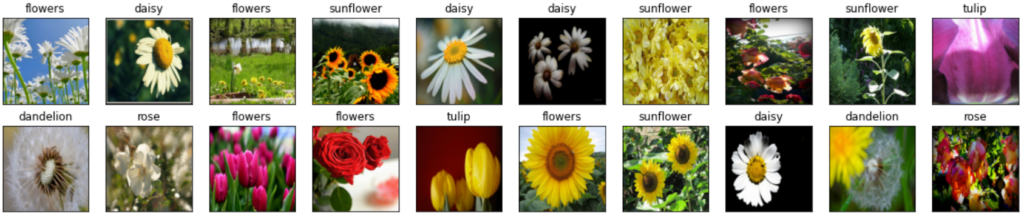

A continuación analizaremos el número de imágenes por categoría

In [ ]:
labels = {}
for label in classes:
  labels[label] = 0
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
for data in data_loader:
  img, label = data
  labels[classes[label.item()]] += 1
print(labels)

{'daisy': 764, 'dandelion': 1052, 'rose': 784, 'sunflower': 733, 'tulip': 984}


Podemos observar que nuestro conjunto de datos está formado por 4323 imágenes, de las cuáles:
* 764 son margaritas (Daisy)
* 1052 son dientes de leon (Dandelion)
* 784 son rosas (Rose)
* 733 son girasoles (Sunflower)
* 984 son tulipanes (Tulip)

**División en Entrenamiento, Validación y Test**

Un paso muy importante cuando entrenamos modelos de Deep Learning y Machine Learning en general, es tener conjuntos de datos para evaluar el modelo en dos fases, durante el entrenamiento y después del entrenamiento. Para el entrenamiento se hará uso de un conjunto de datos de validación, para comprobar que el modelo no esté haciendo overfitting sobre los datos de entrenamiento. Para la fase posterior, se evaluará el modelo con unos datos que nunca haya visto, datos de test.

In [ ]:
from torch.utils.data import random_split
train_set, test_set = random_split(dataset, (int(len(dataset) * 0.7) + 1, int(len(dataset) * 0.3)))
train_set, valid_set = random_split(train_set, (int(len(train_set) * 0.7) + 1, int(len(train_set) * 0.3)))

**Arquitectura del modelo de clasificación de imágenes**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

**Entrenamiento del modelo de clasificación**

Definimos las funciones de coste y el optimizador que utilizaremos.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = Net().to(device)
criterion = nn.CrossEntropyLoss()
# params = cnn.resnet.fc.parameters()
params = cnn.parameters()
optimizer = torch.optim.Adam(params, lr=0.003)

Creamos los DataLoader para cada conjunto de datos, entrenamiento, validación y testeo.

In [ ]:
train_loader = DataLoader(train_set, batch_size=64)
valid_loader = DataLoader(valid_set, batch_size=1)
test_loader = DataLoader(test_set, batch_size=1)

Creamos una función para entrenar el modelo.

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device):
  total_step = len(train_loader)
  num_epochs = 10
  for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for i, (img, target) in enumerate(train_loader):
      img = img.to(device)
      target = target.to(device)
      optimizer.zero_grad()
      output = model(img)

      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * img.size(0)
    model.eval()
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))

Entrenamos el modelo.

In [ ]:
train_model(cnn, train_loader, valid_loader, criterion, optimizer, device)

Creamos una serie de funciones para evaluar el modelo.

In [ ]:
def global_accuracy(model, test_loader):
  correct = 0
  total = 0
  model.to("cpu")
  dataiter = iter(test_loader)
  with torch.no_grad():
    for data in dataiter:
      img, label = data
      output = model(img)
      _, predicted = torch.max(output.data, 1)
      total += label.size(0)
      correct += (predicted == label).sum().item()
  print(f"Accuracy: {100 * correct / total}")
def accuracy_per_class(model, test_loader, classes, device):
  class_correct = list(0. for i in range(5))
  class_total = list(0. for i in range(5))
  cnn.to(device)
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = cnn(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          if(c.item()):
            class_correct[labels.item()] += 1
          class_total[labels.item()] += 1

  for i in range(5):
    print(f"{classes[i]} | Correct: {class_correct[i]} | Total: {class_total[i]}" +
          f" | Accuracy: {class_correct[i] / class_total[i]}")

A continuación evaluamos el modelo.

In [ ]:
global_accuracy(cnn, test_loader)
accuracy_per_class(cnn, test_loader, classes, device)

Analizando el accuracy, podemos ver que el modelo no muestra resultados extraordinarios.